In [1]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt


In [2]:
class simple_method:
    def __init__(self, depth, total_points):

        tot_points = total_points
        
        self.x = np.linspace(0,depth,tot_points) 

        self.M = depth/(tot_points-1) * 0.5 * (np.identity(tot_points)+ np.diag(np.ones(tot_points -1), -1))

In [3]:
layers = 5
segments = 20
length = 30
tot_points = layers*segments


Mx = simple_method(length, tot_points)

res_conc = np.exp(-Mx.x)
beta = np.exp(-Mx.x**2)+0.001
mu1 = ca.SX.sym('mu', Mx.x.shape[0])
mu2 = ca.SX.sym('mu', Mx.x.shape[0])
lam = ca.SX.sym('lam', 2)
sigma = ca.SX.sym('sigma', Mx.x.shape[0])
sigma_p = ca.SX.sym('sigma_p', Mx.x.shape[0])
sigma_bar = ca.SX.sym('sigma_bar', Mx.x.shape[0])
inte = np.ones(tot_points).reshape(1,tot_points) 

gamma0 = 1
gamma1 = 1
gamma2 = 2
gamma3 = 1
gamma4 = 1
gamma5 = 0.5

df1 = (res_conc* gamma1/(gamma0*inte @ (Mx.M @ (sigma*res_conc)) + gamma1)**2-sigma_p*beta/(gamma2+gamma3*inte @ (Mx.M @ (sigma*beta*sigma_p)))) - lam[0]*np.ones(tot_points)
df2 = (gamma4*sigma*beta/(gamma3*inte @ (Mx.M @ (sigma*beta*sigma_p))+gamma4)**2) - lam[1]*np.ones(tot_points)

df = ca.vertcat(df1, df2)
g1 = df + ca.vertcat(mu1, mu2)
g2 = inte @ Mx.M @ sigma_p - 1
g3 = inte @ Mx.M @ sigma - 1
g = ca.vertcat(g1, g2, g3)

f = inte @ Mx.M @ (sigma*mu1) + inte @ Mx.M @ (sigma_p * mu2)

In [8]:
x_out[2*tot_points:4*tot_points]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02608328, 0.0494191 , 0.0666544 , 0.07938399,
       0.08878577, 0.09572971, 0.10085834, 0.10464622, 0.10744387,
       0.10951014, 0.11103624, 0.11216339, 0.11299587, 0.11361072,
       0.11406484, 0.11440024, 0.11464795, 0.11483091, 0.11496604,
       0.11506584, 0.11513956, 0.115194  , 0.11523421, 0.11526391,
       0.11528584, 0.11530204, 0.11531401, 0.11532284, 0.11532937,
       0.11533419, 0.11533775, 0.11534038, 0.11534232, 0.11534376,
       0.11534482, 0.1153456 , 0.11534618, 0.1153466 , 0.11534692,
       0.11534715, 0.11534732, 0.11534745, 0.11534754, 0.11534761,
       0.11534766, 0.1153477 , 0.11534773, 0.11534775, 0.11534777,
       0.11534778, 0.11534779, 0.11534779, 0.1153478 , 0.1153478 ,
       0.1153478 , 0.1153478 , 0.11534781, 0.11534781, 0.11534781,
       0.11534781, 0.11534781, 0.11534781, 0.11534781, 0.11534781,
       0.11534781, 0.11534781, 0.11534781, 0.11534781, 0.11534

In [4]:
import time as time


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 167.00us (  5.22us) 163.77us (  5.12us)        32
       nlp_g  | 534.00us ( 16.69us) 514.71us ( 16.08us)        32
  nlp_grad_f  | 251.00us (  7.61us) 246.21us (  7.46us)        33
   nlp_jac_g  |  11.51ms (348.82us)  11.46ms (347.32us)        33
       total  | 570.93ms (570.93ms) 582.44ms (582.44ms)         1
Solved 0.7517335414886475


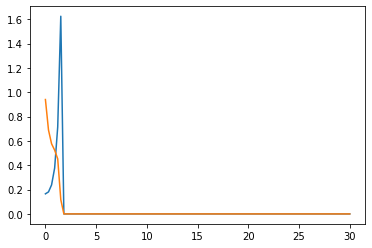

In [7]:
sigmas = ca.vertcat(sigma, sigma_p)
x = ca.vertcat(*[sigmas, mu1, mu2, lam])
lbg = np.zeros(2*(tot_points + 1))
ubg = np.zeros(2*(tot_points + 1))

s_opts = {'ipopt': {'print_level' : 1, 'linear_solver':'mumps', 'hessian_approximation':'limited-memory', 'jac_d_constant':'yes', 'acceptable_iter': 5} }#, 'tol':10**-3, 'acceptable_tol': 10**(-2)}}
prob = {'x': x, 'f': f, 'g': g}
lbx = ca.vertcat(*[np.zeros(x.size()[0] - 2), -ca.inf, -ca.inf])

t0 = time.time()
solver = ca.nlpsol('solver', 'ipopt', prob, s_opts)
sol = solver(lbx = lbx, lbg = lbg, ubg = ubg)
t1 = time.time()

print("Solved", t1-t0)
x_out = np.array(sol['x']).flatten()
#print(x_out)
plt.plot(Mx.x, x_out[0:tot_points])
plt.plot(Mx.x, x_out[tot_points:2*tot_points])

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   2.99ms ( 69.51us) 381.19us (  8.86us)        43
       nlp_g  |   8.58ms (199.51us)   1.07ms ( 24.92us)        43
  nlp_grad_f  |   4.56ms (103.73us) 596.53us ( 13.56us)        44
  nlp_hess_l  | 942.64ms ( 22.44ms) 119.47ms (  2.84ms)        42
   nlp_jac_g  | 207.76ms (  4.72ms)  27.05ms (614.75us)        44
       total  |   3.45 s (  3.45 s) 441.41ms (441.41ms)         1
Solved 1.8632652759552002


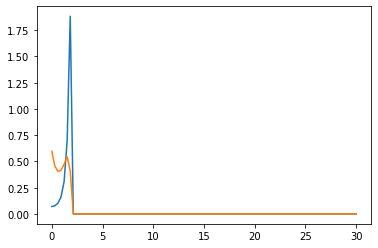

In [145]:
sigmas = ca.vertcat(sigma, sigma_p)
x = ca.vertcat(*[sigmas, mu1, mu2, lam])
lbg = np.zeros(2*(tot_points + 1))
ubg = np.zeros(2*(tot_points + 1))
s_opts = {'ipopt': {'print_level' : 1, 'linear_solver':'ma57'}}
prob = {'x': x, 'f': f, 'g': g}
lbx = ca.vertcat(*[np.zeros(x.size()[0] - 2), -ca.inf, -ca.inf])

t0 = time.time()
solver = ca.nlpsol('solver', 'ipopt', prob, s_opts)
sol = solver(lbx = lbx, lbg = lbg, ubg = ubg)
t1 = time.time()
print("Solved", t1-t0)
x_out = np.array(sol['x']).flatten()
#print(x_out)
plt.plot(Mx.x, x_out[0:tot_points])
plt.plot(Mx.x, x_out[tot_points:2*tot_points])

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  | 628.00us (  9.97us) 635.45us ( 10.09us)        63
       nlp_g  |   6.88ms (109.14us)   6.84ms (108.59us)        63
  nlp_grad_f  |   1.14ms ( 17.83us)   1.04ms ( 16.25us)        64
  nlp_hess_l  |   2.55 s ( 41.10ms)   2.53 s ( 40.88ms)        62
   nlp_jac_g  | 183.72ms (  2.87ms) 182.77ms (  2.86ms)        64
       total  |  13.82 s ( 13.82 s)  13.74 s ( 13.74 s)         1
Solved 91.29399824142456


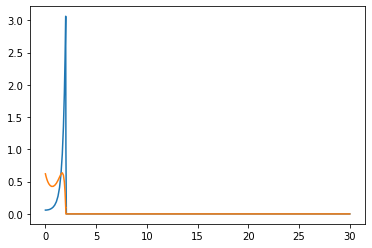

In [65]:
sigmas = ca.vertcat(sigma, sigma_p)
x = ca.vertcat(*[sigmas, mu1, mu2, lam])
lbg = np.zeros(2*(tot_points + 1))
ubg = np.zeros(2*(tot_points + 1))

s_opts = {'ipopt': {'print_level' : 1, 'linear_solver':'ma27'}}
prob = {'x': x, 'f': f, 'g': g}
lbx = ca.vertcat(*[np.zeros(x.size()[0] - 2), -ca.inf, -ca.inf])

t0 = time.time()
solver = ca.nlpsol('solver', 'ipopt', prob, s_opts)
sol = solver(lbx = lbx, lbg = lbg, ubg = ubg)
t1 = time.time()

print("Solved", t1-t0)
x_out = np.array(sol['x']).flatten()
#print(x_out)
plt.plot(Mx.x, x_out[0:tot_points])
plt.plot(Mx.x, x_out[tot_points:2*tot_points])

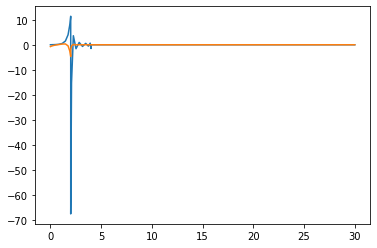

In [55]:
plt.plot(Mx.x, Mx.D @ x_out[0:tot_points])

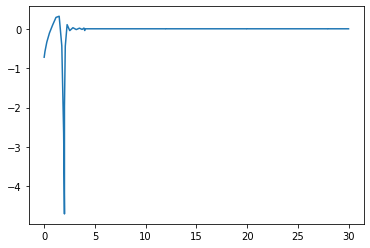

In [56]:
plt.plot(Mx.x, Mx.D @ x_out[tot_points:2*tot_points])

In [9]:
x_out[-2:]

array([0.09074956, 0.06184802])

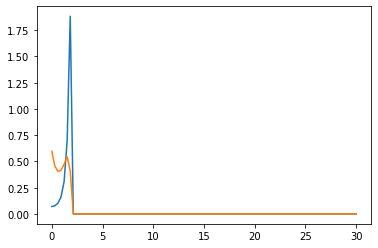

In [10]:
plt.plot(Mx.x, x_out[0:tot_points])
plt.plot(Mx.x, x_out[tot_points:2*tot_points])

In [11]:
inte @ (Mx.M @ Mx.x)

array([450.])

In [12]:
inte @ Mx.M @ (x_out[tot_points*2:tot_points*3] * x_out[0:tot_points])

array([2.1939846e-07])

In [13]:
inte @ Mx.M @ (x_out[0:tot_points])

array([1.])

In [14]:
inte @ Mx.M @ (x_out[tot_points:2*tot_points])

array([1.])

In [15]:
x_out[tot_points:2*tot_points]

array([5.96182638e-01, 4.54809032e-01, 4.05666573e-01, 4.15879164e-01,
       4.73011839e-01, 5.44086025e-01, 4.10353221e-01, 1.23672466e-07,
       1.23674996e-07, 1.23675159e-07, 1.23675186e-07, 1.23675192e-07,
       1.23675195e-07, 1.23675196e-07, 1.23675197e-07, 1.23675198e-07,
       1.23675198e-07, 1.23675198e-07, 1.23675199e-07, 1.23675199e-07,
       1.23675199e-07, 1.23675199e-07, 1.23675199e-07, 1.23675199e-07,
       1.23675199e-07, 1.23675199e-07, 1.23675199e-07, 1.23675199e-07,
       1.23675199e-07, 1.23675199e-07, 1.23675199e-07, 1.23675199e-07,
       1.23675199e-07, 1.23675199e-07, 1.23675199e-07, 1.23675199e-07,
       1.23675199e-07, 1.23675199e-07, 1.23675199e-07, 1.23675199e-07,
       1.23675199e-07, 1.23675199e-07, 1.23675199e-07, 1.23675199e-07,
       1.23675199e-07, 1.23675199e-07, 1.23675199e-07, 1.23675199e-07,
       1.23675199e-07, 1.23675199e-07, 1.23675199e-07, 1.23675199e-07,
       1.23675199e-07, 1.23675199e-07, 1.23675199e-07, 1.23675199e-07,
      

In [16]:
x_out[tot_points*3:tot_points*4]

array([3.87139468e-09, 8.18286642e-09, 1.03848413e-08, 9.88306718e-09,
       7.47968265e-09, 5.19351855e-09, 1.01560910e-08, 6.18480129e-02,
       6.18480187e-02, 6.18480193e-02, 6.18480194e-02, 6.18480194e-02,
       6.18480194e-02, 6.18480194e-02, 6.18480194e-02, 6.18480194e-02,
       6.18480194e-02, 6.18480194e-02, 6.18480194e-02, 6.18480194e-02,
       6.18480194e-02, 6.18480194e-02, 6.18480194e-02, 6.18480194e-02,
       6.18480194e-02, 6.18480194e-02, 6.18480194e-02, 6.18480194e-02,
       6.18480194e-02, 6.18480194e-02, 6.18480194e-02, 6.18480194e-02,
       6.18480194e-02, 6.18480194e-02, 6.18480194e-02, 6.18480194e-02,
       6.18480194e-02, 6.18480194e-02, 6.18480194e-02, 6.18480194e-02,
       6.18480194e-02, 6.18480194e-02, 6.18480194e-02, 6.18480194e-02,
       6.18480194e-02, 6.18480194e-02, 6.18480194e-02, 6.18480194e-02,
       6.18480194e-02, 6.18480194e-02, 6.18480194e-02, 6.18480194e-02,
       6.18480194e-02, 6.18480194e-02, 6.18480194e-02, 6.18480194e-02,
      